<a href="https://colab.research.google.com/github/abakashi/dnc_deliverable2_walmart/blob/main/Deliverable__2_mc_g1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deliverable 2 - Grupo 01 - DEX04
## Importe das bibliotecas e criação do DataFrame.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import random as rd
from IPython.display import display, HTML, display_html
from itertools import chain,cycle

# Carregando .csv para o DataFrame
dataset = pd.read_csv('/content/drive/MyDrive/Walmart.csv')

# Convertendo os dados de data de String para DateTime
dataset.Date = pd.to_datetime(dataset.Date)

# Criando uma coluna com o número da semana para potencial consulta de 
# resultados
dataset['Week_Number'] = dataset.Date.dt.isocalendar().week


### Sobre os dados
Este é o conjunto de dados de 05-02-2010 até 01-11-2012 do WalmartStoresales. 
Neste arquivo você encontrará as seguintes variáveis:

**Store** - the store number

**Date** - the week of sales

**Weekly_Sales** - sales for the given store

**Holiday_Flag** - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week

**Temperature** - Temperature on the day of sale

**Fuel_Price** - Cost of fuel in the region

**CPI** – Prevailing consumer price index

**Unemployment** - Prevailing unemployment rate

**Holiday Events**\
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\

Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## Questionamento:
**Com base nos dados fornecidos, em qual loja deve-se investir?**

Iniciando os Estudos:

In [ ]:
# Criando listas com strings das datas de feriado para comparação futura
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'] 
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
labourday_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
superbowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']


In [ ]:
#Criando funções de utilidades.
# Criando uma função para filtrar os dataframes por lista de datas de feriados
def df_datefilter(dataframe, date_list):
  return dataframe[dataframe.Date.isin(date_list)]

# Criando uma função para pegar as semanas das datas.
def week_getter(datelist):
  weeks = set()
  for date in datelist:
    if date[5] == '0':
      yr = int(date[:4])
      mth = int(date[6:7])
      day = int(date[8:10])
      weeks.add(dt.date(yr, mth, day).isocalendar()[1])
    else:
      yr = int(date[:4])
      mth = int(date[5:7])
      day = int(date[8:10])
      weeks.add(dt.date(yr, mth, day).isocalendar()[1])
  return weeks

# Função para filtrar o dataframe por lista com números de semanas dos feriados
def df_weekfilter(dataframe, weeklist):
  return dataframe[dataframe.Week_Number.isin(weeklist)]

#Função para calcular o limite dos outliers:
def inner_fences(dataframe, variable):
  q1 = dataframe[str(variable)].quantile(0.25)
  q3 = dataframe[str(variable)].quantile(0.75)
  iqr = (q3 - q1) * 1.5
  return (( q1 - iqr ), ( q3 + iqr ))
 
#Função para montar uma tupla com as datas dos quartos de anos
def quarter_getter(year, quarter):
  quarters = (None, ('-01-01', '-03-31'), ('-04-01', '-06-30'),
              ('-07-01', '-09-30'), ('-10-01', '-12-31'))
  dates = list()
  for date in quarters[int(quarter)]:
    dates.append(str(year)+date)
  return tuple(dates)

#Função para montar dataframes por quarters
def ds_quarter_getter(dataframe, year, quarter):
  return dataframe[(dataframe['Date'] >= quarter_getter(year, quarter)[0]) &
                   (dataframe['Date'] <= quarter_getter(year, quarter)[1])]

#Função para plotar os quarters das lojas nos anos
def q_sale_wksl_plotter(dataframe, year):
  q1 = ds_quarter_getter(dataframe, year, 1)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()
  q2 = ds_quarter_getter(dataframe, year, 2)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()
  q3 = ds_quarter_getter(dataframe, year, 3)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()
  q4 = ds_quarter_getter(dataframe, year, 4)[['Store',
      'Weekly_Sales']].groupby('Store').sum().reset_index()


  fig, ax = plt.subplots(2, 2, figsize=(18, 20))
  sns.barplot(x=q1['Weekly_Sales'],y=q1['Store'], orient='h',
              ax=ax[0,0], color="cornflowerblue")
  ax[0,0].set_title(f'Quarter 1 - {year}')
  sns.barplot(x=q2['Weekly_Sales'],y=q2['Store'], orient='h',
              ax=ax[0,1], color="royalblue")
  ax[0,1].set_title(f'Quarter 2 - {year}')
  sns.barplot(x=q3['Weekly_Sales'],y=q3['Store'], orient='h',
              ax=ax[1,0], color="teal")
  ax[1,0].set_title(f'Quarter 3 - {year}')
  sns.barplot(x=q4['Weekly_Sales'],y=q4['Store'], orient='h',
              ax=ax[1,1], color="cadetblue")
  ax[1,1].set_title(f'Quarter 4 - {year}')
  plt.show()

# Definindo função que mostra mais de 1 dataframe por saída
def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'"
        ).set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


#Função para pegar a média de um campo de um dataset
def mean_getter(dataset, column):
  return dataset[column].mean()



In [ ]:
#Checando se as variáveis têm valores nulos
variaveis = list(dataset.columns)
v_nulo = list()
for variavel in variaveis:
  if dataset[variavel].hasnans:
    v_nulo.append(variavel)
print(v_nulo) #sem valores nulos


[]


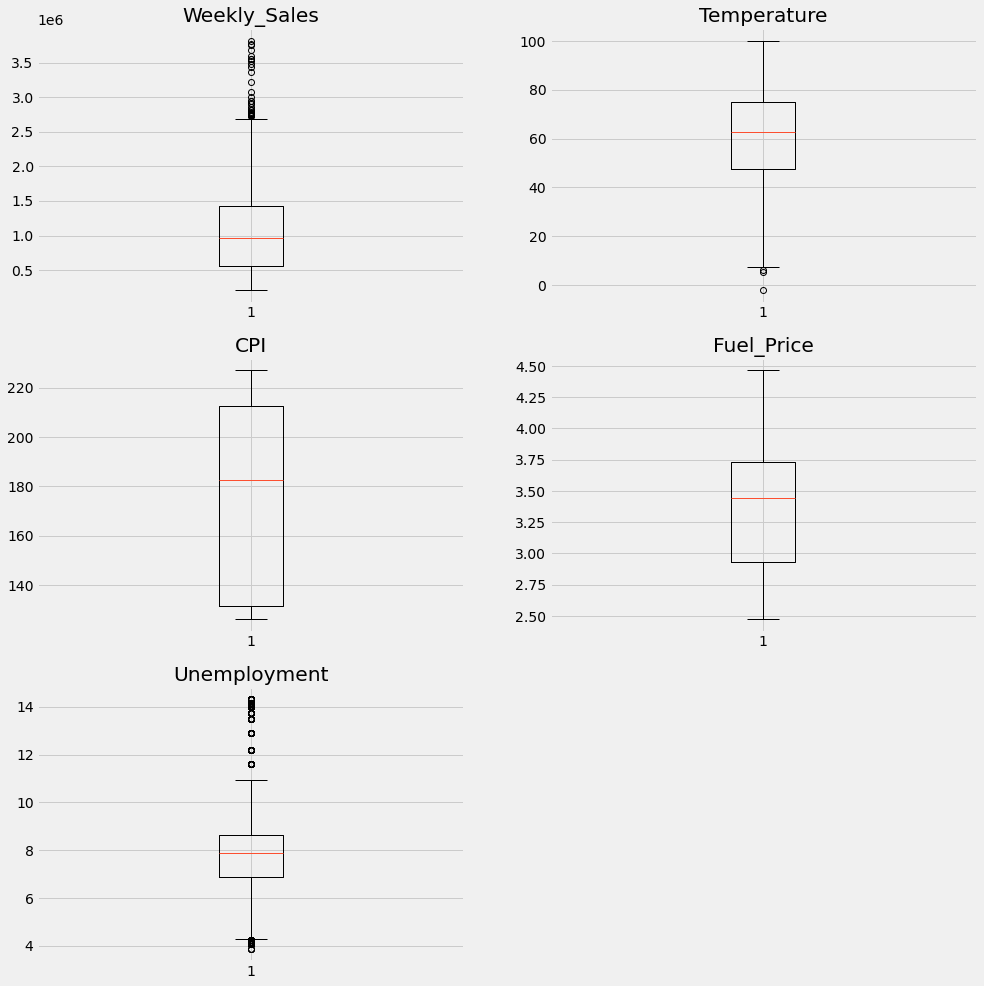

In [ ]:
# Visualizando presença de outliers em variáveis quantitativas.

fig, ax = plt.subplots(3,2, figsize=(15,16))

ax[0,0].boxplot(dataset.Weekly_Sales)
ax[0,0].set_title(dataset['Weekly_Sales'].name)

ax[0,1].boxplot(dataset.Temperature)
ax[0,1].set_title(dataset['Temperature'].name)

ax[1,0].boxplot(dataset.CPI)
ax[1,0].set_title(dataset['CPI'].name)

ax[1,1].boxplot(dataset.Fuel_Price)
ax[1,1].set_title(dataset['Fuel_Price'].name)

ax[2,0].boxplot(dataset.Unemployment)
ax[2,0].set_title(dataset['Unemployment'].name)

ax[2,1].set_visible(False)

plt.show()

#outliers detectados no Weekly_Sales (esperado), Temperatura e Unemployment.


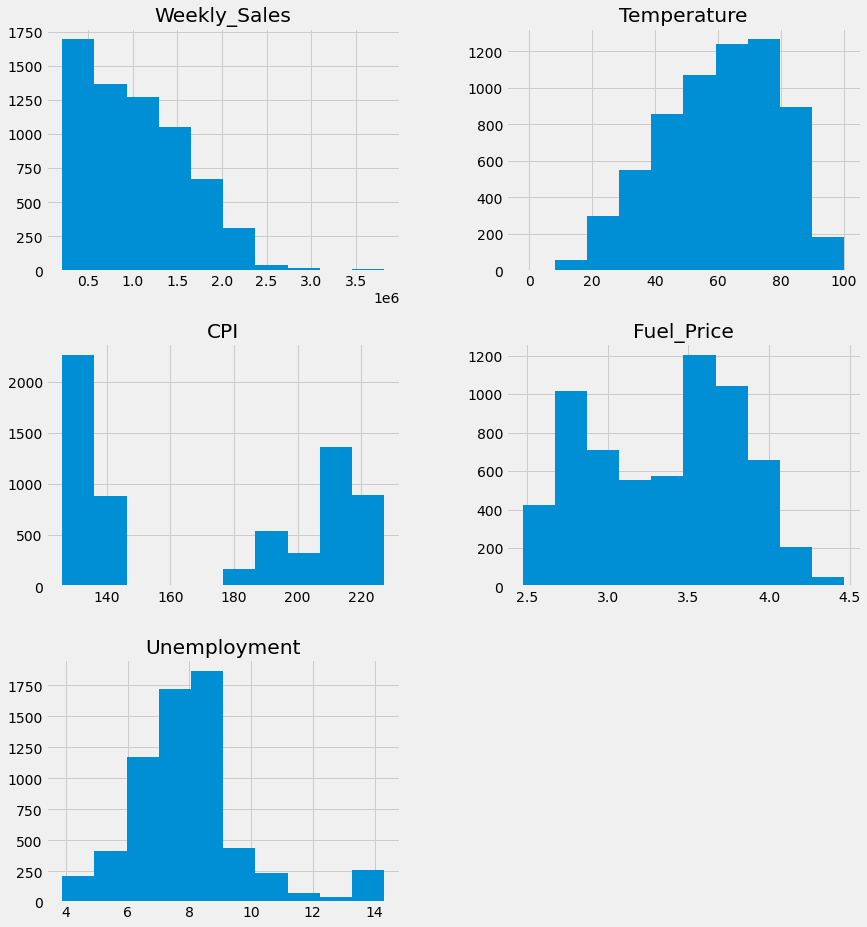

In [ ]:
#Visualizando variáveis quantitativas.
plt.style.use('fivethirtyeight')
dataset.hist(column=['Weekly_Sales', 'Temperature', 'CPI', 'Fuel_Price',
                       'Unemployment'], figsize=(13,15))
plt.show()

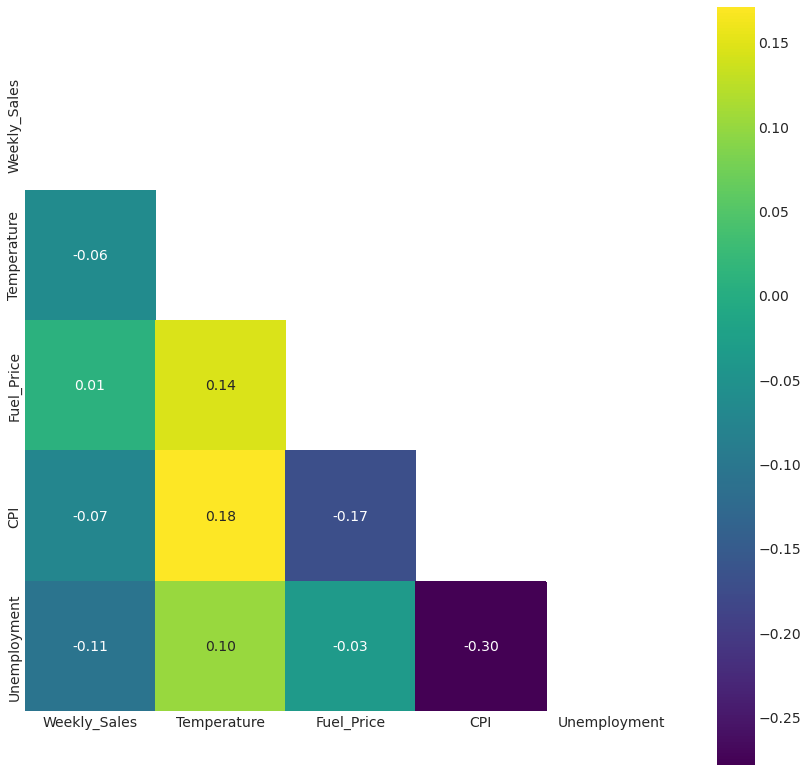

In [ ]:
#checagem da matriz de correlação.

ds_hmap = dataset.drop(labels=['Store', 'Date', 'Holiday_Flag', 'Week_Number']
                         , axis=1)

mask = np.zeros_like(ds_hmap.corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(13,13))
    ax = sns.heatmap(ds_hmap.corr(),mask=mask, square=True, annot=True,
                     fmt='.2f', cmap='viridis', robust=True)
plt.show()
#Correlação muito fraca das variáveis quantitativas. Atentar para CPI e 
#Unemployment - CPI e Temperature.

##Analisando as vendas semanais dos quarters de 2010.

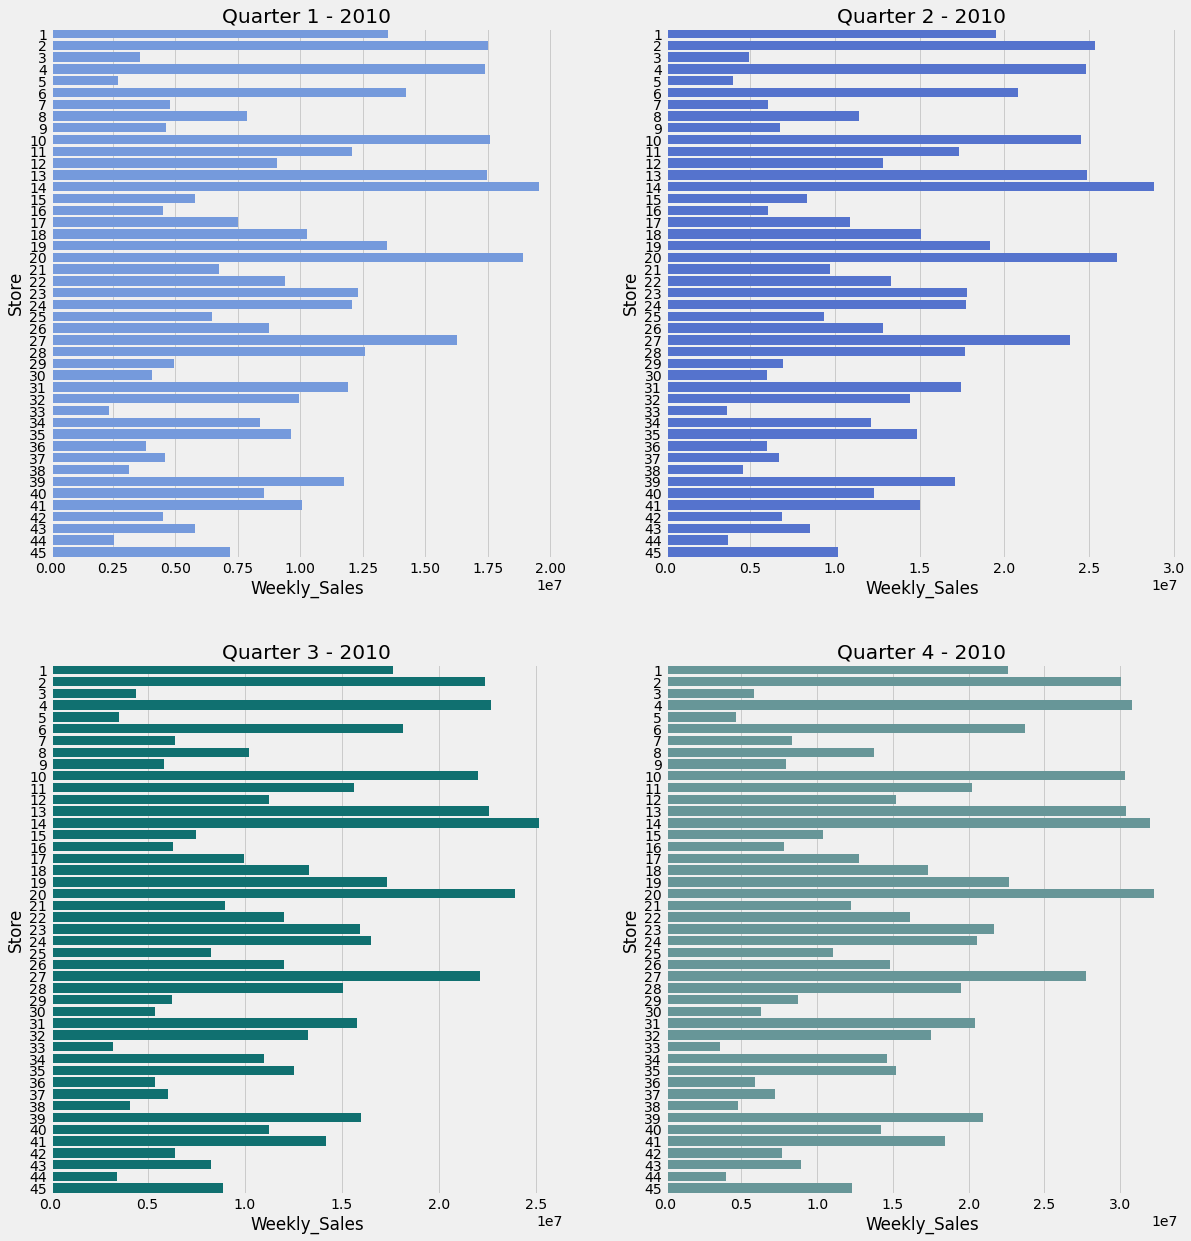

In [ ]:
q_sale_wksl_plotter(dataset, 2010)

## Analisando as vendas semanais dos quarters de 2011

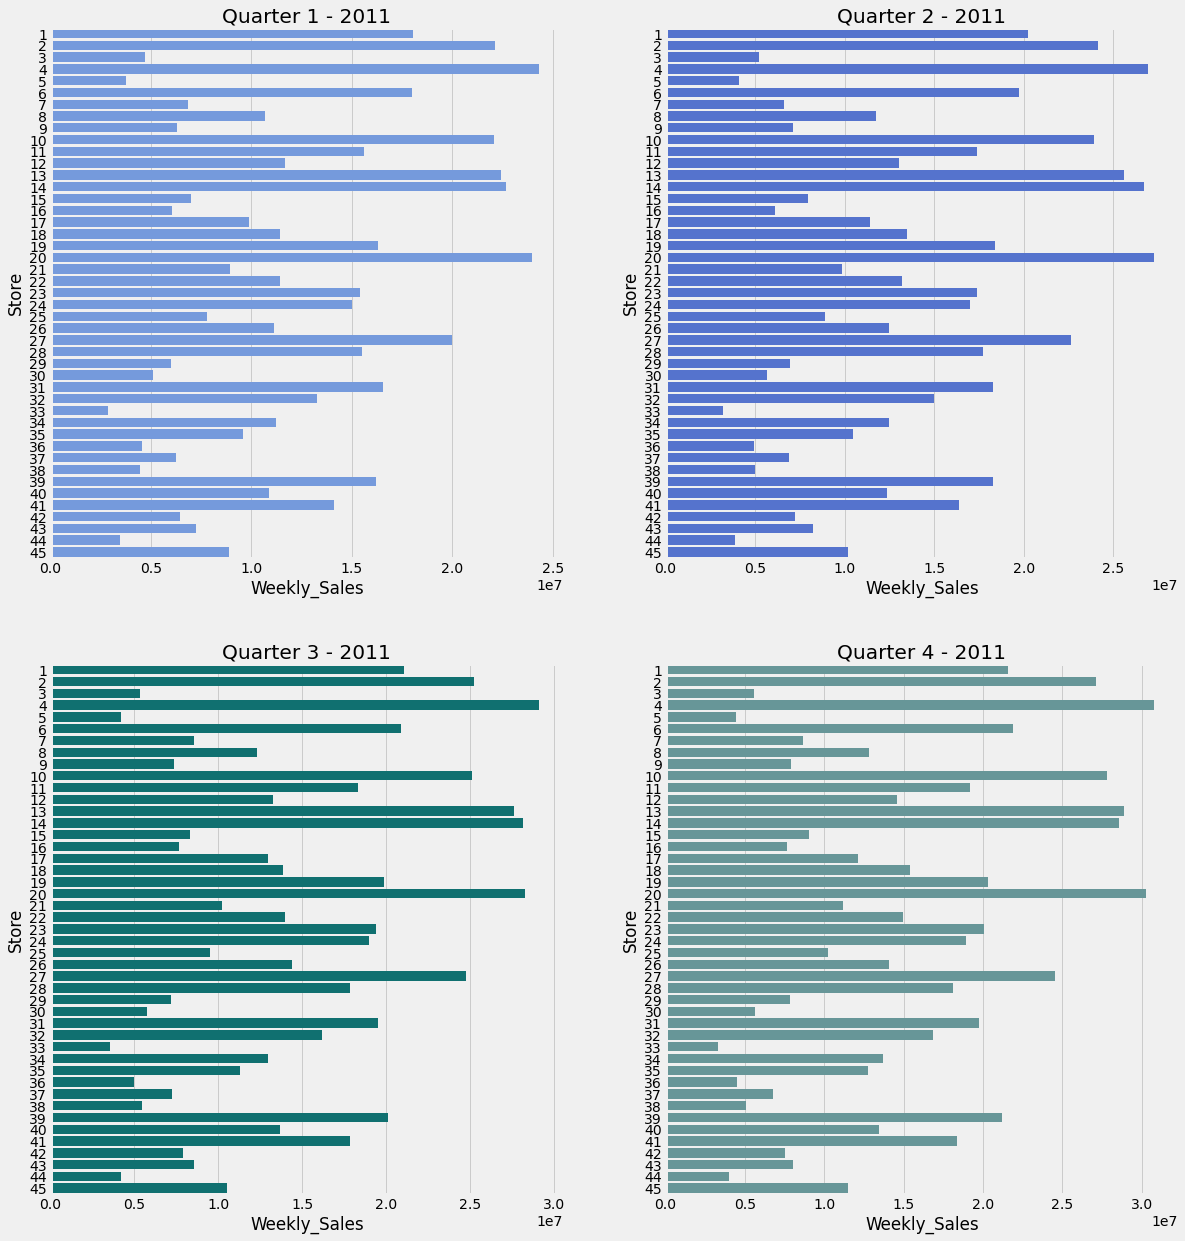

In [ ]:
q_sale_wksl_plotter(dataset, 2011)

##Analisando as vendas semanais dos quarters de 2012

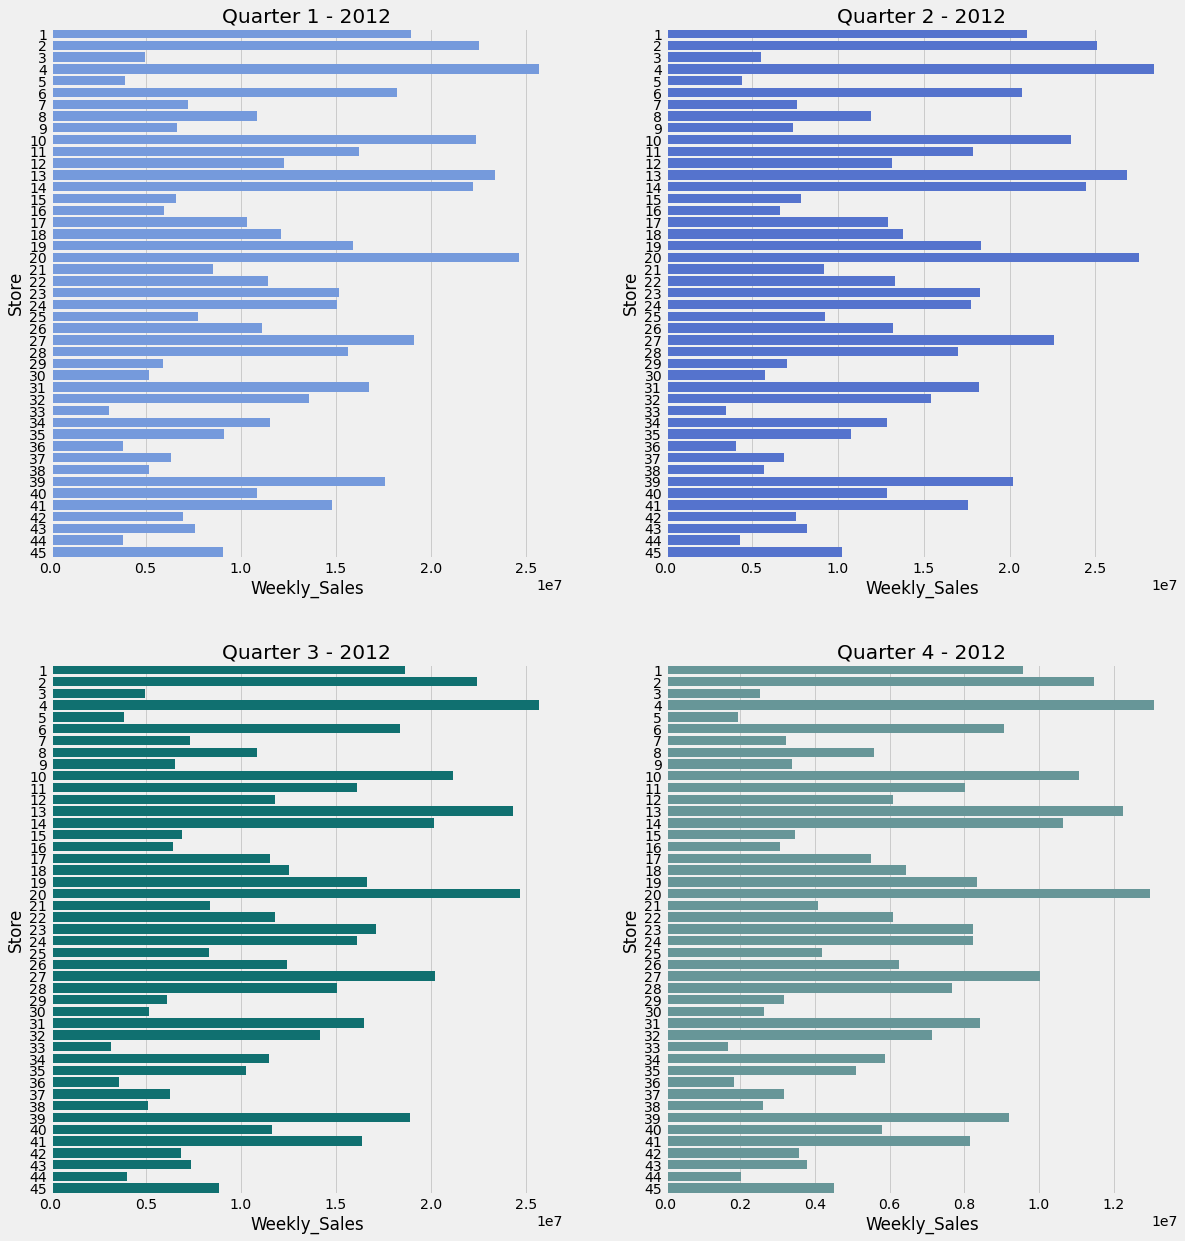

In [ ]:
q_sale_wksl_plotter(dataset, 2012)

In [ ]:
# Filtrando o dataset por vendas nos feriados de natal (Usando dataset sem Outliers)
ds_christmas = df_weekfilter(dataset, week_getter(christmas_dates))
ds_thanksgiving = df_weekfilter(dataset, week_getter(thanksgiving_dates))
ds_labourday = df_weekfilter(dataset, week_getter(labourday_dates))
ds_superbowl = df_weekfilter(dataset, week_getter(superbowl_dates)) 



# Observando quais lojas mais venderam no feriado do Natal de 2010
chr_2010 = ds_christmas[['Store', 'Date', 'Weekly_Sales']][ds_christmas['Date'
          ].dt.year == 2010].sort_values('Weekly_Sales', ascending=False)

chr_2011 = ds_christmas[['Store', 'Date', 'Weekly_Sales']][ds_christmas['Date'
          ].dt.year == 2011].sort_values('Weekly_Sales', ascending=False)

display_side_by_side([chr_2010, chr_2011], ['2010', '2011'])

,Store,Date,Weekly_Sales
2764,20,2010-12-31 00:00:00,1799737.790000
476,4,2010-12-31 00:00:00,1794868.740000
190,2,2010-12-31 00:00:00,1750434.550000
1334,10,2010-12-31 00:00:00,1707298.140000
1763,13,2010-12-31 00:00:00,1675292.000000
1906,14,2010-12-31 00:00:00,1623716.460000
762,6,2010-12-31 00:00:00,1464050.020000
3765,27,2010-12-31 00:00:00,1440963.000000
47,1,2010-12-31 00:00:00,1367320.010000
2621,19,2010-12-31 00:00:00,1275146.940000


In [ ]:
# Observando as vendas semanais nos períodos de ação de graças.
thx_2010 = ds_thanksgiving[['Store', 'Date', 'Weekly_Sales']][ds_thanksgiving[
          'Date'].dt.year == 2010].sort_values('Weekly_Sales', ascending=False)
thx_2011 = ds_thanksgiving[['Store', 'Date', 'Weekly_Sales']][ds_thanksgiving[
          'Date'].dt.year == 2011].sort_values('Weekly_Sales', ascending=False)
thx_2012 = ds_thanksgiving[['Store', 'Date', 'Weekly_Sales']][ds_thanksgiving[
          'Date'].dt.year == 2012].sort_values('Weekly_Sales', ascending=False)

display_side_by_side([thx_2010.head(36), thx_2011.head(36)], ['2010', '2011'])

,Store,Date,Weekly_Sales
1329,10,2010-11-26 00:00:00,2939946.380000
1901,14,2010-11-26 00:00:00,2921709.710000
2759,20,2010-11-26 00:00:00,2811634.040000
471,4,2010-11-26 00:00:00,2789469.450000
1758,13,2010-11-26 00:00:00,2766400.050000
185,2,2010-11-26 00:00:00,2658725.290000
3760,27,2010-11-26 00:00:00,2627910.750000
757,6,2010-11-26 00:00:00,2267452.400000
430,4,2010-12-02 00:00:00,2188307.390000
1288,10,2010-12-02 00:00:00,2176028.520000


In [ ]:
# Observando as vendas semanais nos períodos do dia do trabalho.
lab_2010 = ds_labourday[['Store', 'Date', 'Weekly_Sales']][ds_labourday[
          'Date'].dt.year == 2010].sort_values('Weekly_Sales', ascending=False)
lab_2011 = ds_labourday[['Store', 'Date', 'Weekly_Sales']][ds_labourday[
          'Date'].dt.year == 2011].sort_values('Weekly_Sales', ascending=False)
lab_2012 = ds_labourday[['Store', 'Date', 'Weekly_Sales']][ds_labourday[
          'Date'].dt.year == 2012].sort_values('Weekly_Sales', ascending=False)

display_side_by_side([lab_2010.head(36), lab_2011.head(36), lab_2012.head(36)], 
                     ['2010', '2011', '2012'])

,Store,Date,Weekly_Sales
1881,14,2010-09-07 00:00:00,2236209.130000
3740,27,2010-09-07 00:00:00,2119163.010000
2739,20,2010-09-07 00:00:00,2107285.850000
165,2,2010-09-07 00:00:00,1880902.620000
1738,13,2010-09-07 00:00:00,1870843.900000
451,4,2010-09-07 00:00:00,1812208.220000
1309,10,2010-09-07 00:00:00,1769793.370000
737,6,2010-09-07 00:00:00,1690317.990000
3311,24,2010-09-07 00:00:00,1665502.550000
2596,19,2010-09-07 00:00:00,1577541.240000


In [ ]:
# Observando as vendas semanais nos períodos do superbowl.
super_2010 = ds_superbowl[['Store', 'Date', 'Weekly_Sales']][ds_superbowl[
          'Date'].dt.year == 2010].sort_values('Weekly_Sales', ascending=False)
super_2011 = ds_superbowl[['Store', 'Date', 'Weekly_Sales']][ds_superbowl[
          'Date'].dt.year == 2011].sort_values('Weekly_Sales', ascending=False)
super_2012 = ds_superbowl[['Store', 'Date', 'Weekly_Sales']][ds_superbowl[
          'Date'].dt.year == 2012].sort_values('Weekly_Sales', ascending=False)

display_side_by_side([super_2011.head(36)], 
                     [ '2011'])

,Store,Date,Weekly_Sales
2812,20,2011-02-12 00:00:00,2298776.830000
524,4,2011-02-12 00:00:00,2180999.260000
1954,14,2011-02-12 00:00:00,2143080.570000
2799,20,2011-02-09 00:00:00,2141765.980000
511,4,2011-02-09 00:00:00,2078420.310000
1382,10,2011-02-12 00:00:00,2068097.180000
1811,13,2011-02-12 00:00:00,2051315.660000
238,2,2011-02-12 00:00:00,1954952.000000
1798,13,2011-02-09 00:00:00,1953628.820000
225,2,2011-02-09 00:00:00,1809119.700000


In [ ]:
# Mostrando as lojas que estão acima da média para cada feriado: Superbowl

best10_superbowl = super_2011[super_2011['Weekly_Sales'] >
                mean_getter(super_2011, 'Weekly_Sales')].head(20)
best10_superbowl

,Store,Date,Weekly_Sales
2812,20,2011-02-12,2298776.83
524,4,2011-02-12,2180999.26
1954,14,2011-02-12,2143080.57
2799,20,2011-02-09,2141765.98
511,4,2011-02-09,2078420.31
1382,10,2011-02-12,2068097.18
1811,13,2011-02-12,2051315.66
238,2,2011-02-12,1954952.00
1798,13,2011-02-09,1953628.82
225,2,2011-02-09,1809119.70


In [ ]:
# Mostrando as lojas que estão acima da média para cada feriado: Dia do Trabalho

lab_12_11 = lab_2012[lab_2012['Weekly_Sales'] >
            mean_getter(lab_2012, 'Weekly_Sales')].merge(lab_2011[
            lab_2011['Weekly_Sales'] > mean_getter(lab_2011, 'Weekly_Sales')],
            how='inner', on=['Store'])

best_labor = lab_2010[lab_2010['Weekly_Sales'] > mean_getter(lab_2010,
            'Weekly_Sales')].merge(lab_12_11[lab_12_11['Weekly_Sales_y'] 
            > mean_getter(lab_12_11, 'Weekly_Sales_y')], how='inner',
            on='Store')

best_labor


,Store,Date,Weekly_Sales,Date_x,Weekly_Sales_x,Date_y,Weekly_Sales_y
0,14,2010-09-07,2236209.13,2012-09-03,2020839.31,2011-09-09,2202742.90
1,27,2010-09-07,2119163.01,2012-09-03,1607343.41,2011-09-09,1911470.84
2,20,2010-09-07,2107285.85,2012-09-03,2139265.40,2011-09-09,2050542.56
3,2,2010-09-07,1880902.62,2012-09-03,1937628.26,2011-09-09,1748000.65
4,13,2010-09-07,1870843.90,2012-09-03,1986445.65,2011-09-09,1872921.31
5,4,2010-09-07,1812208.22,2012-09-03,2202450.81,2011-09-09,2093139.01
6,10,2010-09-07,1769793.37,2012-09-03,1917483.10,2011-09-09,1670579.82


In [ ]:
# Mostrando as lojas que estão acima da média para cada feriado: Ação de Graças
best_thx = thx_2011[thx_2011['Weekly_Sales'] > mean_getter(thx_2011, 
           'Weekly_Sales')].merge(thx_2010[thx_2010['Weekly_Sales'] > 
           mean_getter(thx_2010, 'Weekly_Sales')], how='inner', on=['Store']
           ).drop_duplicates(subset=["Store"], keep='first')
best_thx

,Store,Date_x,Weekly_Sales_x,Date_y,Weekly_Sales_y
0,4,2011-11-25,3004702.33,2010-11-26,2789469.45
3,10,2011-11-25,2950198.64,2010-11-26,2939946.38
6,20,2011-11-25,2906233.25,2010-11-26,2811634.04
9,13,2011-11-25,2864170.61,2010-11-26,2766400.05
12,14,2011-11-25,2685351.81,2010-11-26,2921709.71
15,2,2011-11-25,2614202.30,2010-11-26,2658725.29
18,27,2011-11-25,2504400.71,2010-11-26,2627910.75
21,39,2011-11-25,2338832.40,2010-11-26,2149355.20
24,6,2011-11-25,2249811.55,2010-11-26,2267452.40
27,23,2011-11-25,2057059.53,2010-11-26,2072685.05


In [ ]:
# Mostrando as lojas que estão acima da média para cada feriado: Natal
best_chr = chr_2011[chr_2011['Weekly_Sales'] > mean_getter(chr_2011, 
           'Weekly_Sales')].merge(chr_2010[chr_2010['Weekly_Sales'] > 
           mean_getter(chr_2010, 'Weekly_Sales')], how='inner', on=['Store']
           ).drop_duplicates(subset=["Store"], keep='first')

best_chr

,Store,Date_x,Weekly_Sales_x,Date_y,Weekly_Sales_y
0,20,2011-12-30,2043245.00,2010-12-31,1799737.79
1,4,2011-12-30,2007105.86,2010-12-31,1794868.74
2,13,2011-12-30,1969056.91,2010-12-31,1675292.00
3,10,2011-12-30,1930690.37,2010-12-31,1707298.14
4,14,2011-12-30,1914148.89,2010-12-31,1623716.46
5,2,2011-12-30,1874226.52,2010-12-31,1750434.55
6,27,2011-12-30,1650604.60,2010-12-31,1440963.00
7,6,2011-12-30,1598080.52,2010-12-31,1464050.02
8,39,2011-12-30,1537139.56,2010-12-31,1230012.16
9,1,2011-12-30,1497462.72,2010-12-31,1367320.01


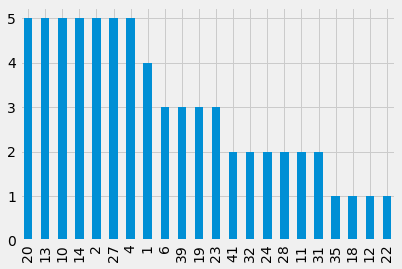

In [ ]:
#Segregar as lojas mais bem colocadas nos datasets dos feriados
best_stores = pd.Series(list(best_chr['Store']) + list(best_thx['Store']) + 
                        list(best_labor['Store']) + 
                        list(best10_superbowl['Store']), name='Lojas')
best_stores.value_counts().plot(kind='bar')
#Lojas 20, 13, 10, 14, 2, 27 e 4 empatadas.

In [ ]:
#Critérios de desempate - faturamento total

tot_loja20 = {'loja20':dataset.loc[dataset['Store'] == 20]['Weekly_Sales'].sum()}
tot_loja13 = {'loja13':dataset.loc[dataset['Store'] == 13]['Weekly_Sales'].sum()}
tot_loja10 = {'loja10':dataset.loc[dataset['Store'] == 10]['Weekly_Sales'].sum()}
tot_loja14 = {'loja14':dataset.loc[dataset['Store'] == 14]['Weekly_Sales'].sum()}
tot_loja02 = {'loja02':dataset.loc[dataset['Store'] == 2]['Weekly_Sales'].sum()}
tot_loja27 = {'loja27':dataset.loc[dataset['Store'] == 24]['Weekly_Sales'].sum()}
tot_loja04 = {'loja04':dataset.loc[dataset['Store'] == 4]['Weekly_Sales'].sum()}

lojas = [tot_loja02, tot_loja04, tot_loja10, tot_loja13, tot_loja14, tot_loja20, tot_loja27]

sorted(lojas, key=lambda x: tuple(x.items())[0][1], reverse=True)

#loja 20 ganha no faturamento total

[{'loja20': 301397792.46000004},
 {'loja04': 299543953.38},
 {'loja14': 288999911.34000003},
 {'loja13': 286517703.8},
 {'loja02': 275382440.97999996},
 {'loja10': 271617713.89},
 {'loja27': 194016021.28000003}]

In [ ]:
#Critérios de desempate - média de faturamento
tot_loja20 = {'loja20':dataset.loc[dataset['Store'] == 20]['Weekly_Sales'].mean()}
tot_loja13 = {'loja13':dataset.loc[dataset['Store'] == 13]['Weekly_Sales'].mean()}
tot_loja10 = {'loja10':dataset.loc[dataset['Store'] == 10]['Weekly_Sales'].mean()}
tot_loja14 = {'loja14':dataset.loc[dataset['Store'] == 14]['Weekly_Sales'].mean()}
tot_loja02 = {'loja02':dataset.loc[dataset['Store'] == 2]['Weekly_Sales'].mean()}
tot_loja27 = {'loja27':dataset.loc[dataset['Store'] == 24]['Weekly_Sales'].mean()}
tot_loja04 = {'loja04':dataset.loc[dataset['Store'] == 4]['Weekly_Sales'].mean()}

lojas = [tot_loja02, tot_loja04, tot_loja10, tot_loja13, tot_loja14, tot_loja20, tot_loja27]

sorted(lojas, key=lambda x: tuple(x.items())[0][1], reverse=True)
#Loja 20 ganha na média de faturamento.

[{'loja20': 2107676.8703496507},
 {'loja04': 2094712.9606993007},
 {'loja14': 2020978.400979021},
 {'loja13': 2003620.306293707},
 {'loja02': 1925751.3355244761},
 {'loja10': 1899424.572657342},
 {'loja27': 1356755.393566433}]

In [ ]:
#Critério de desempate -  Qual loja performa melhor num cenário onde o índice de
#desemprego é maior que a média.
media_desem = dataset['Unemployment'].mean()

dataset[dataset['Unemployment'] > media_desem].groupby('Store').mean('Weekly_Sales'
).reset_index().sort_values('Weekly_Sales', ascending=False)

#Loja 20 consegue se manter em um cenário de desemprego acima da média.

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week_Number
11,20,2.068378e+06,0.125000,34.896250,2.793625,204.390905,8.187000,21.125
7,14,2.020978e+06,0.069930,57.790979,3.417608,186.285678,8.648748,26.0
2,4,1.978049e+06,0.125000,42.328750,2.644250,126.551397,8.623000,21.125
1,2,1.962801e+06,0.083333,64.013000,2.787717,211.303311,8.151617,25.616667
6,13,1.930742e+06,0.047619,47.087143,2.823952,126.398195,8.186619,21.47619
4,10,1.897781e+06,0.068966,72.983678,3.356379,127.448876,8.948379,25.356322
17,27,1.764814e+06,0.064103,55.701538,3.540538,139.362824,8.121244,25.448718
0,1,1.522330e+06,0.125000,47.212500,2.617375,211.238972,8.106000,21.125
10,19,1.475019e+06,0.067568,56.375676,3.338486,134.445516,8.160662,27.486486
29,39,1.372823e+06,0.068966,70.989885,3.052678,211.615356,8.378460,25.356322


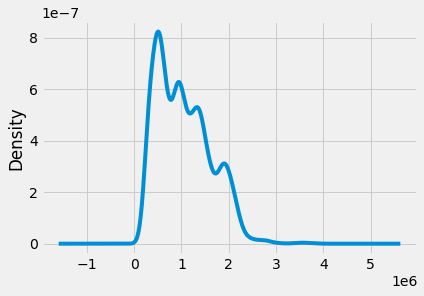

In [ ]:
# Plotando a densidade dos valores das vendas semanais.
dataset['Weekly_Sales'].plot.density()

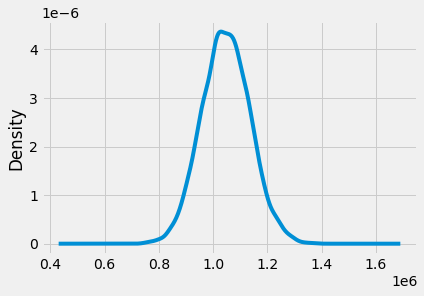

In [ ]:
#Aplicando o Teorema do limite central.
cent_means = list()
for _ in range(6500):
  sample = rd.sample(list(dataset['Weekly_Sales']), k=40)
  cent_means.append(sum(sample)/len(sample))

cent_means = pd.Series(cent_means)


std_dev = cent_means.std()
mean = cent_means.mean()
limit = ((mean-std_dev), (mean+std_dev))


cent_means.plot.density()

In [ ]:
mean_stores = dataset[['Store', 'Weekly_Sales']].groupby('Store'
).mean().sort_values('Weekly_Sales', ascending=False).reset_index()

#Definindo as máscaras dos intervalos iniciais e finais da análise.
min_lim = mean_stores['Weekly_Sales'] > mean
max_lim = mean_stores['Weekly_Sales'] < limit[1]

mean_stores[min_lim & max_lim]

,Store,Weekly_Sales
18,18,1.084718e+06


A loja mais rentável é a loja 20 em diferentes cenários, certamente é uma loja que merece os investimentos para poder se desenvolver ainda mais.

Entretanto, usando uma abordagem mais centrada em lojas que a pesquisa sujere que não alcançaram o seu potencial; usando o método do teorema do limite central, levando em conta lojas acima da média em um desvio padrão, podemos concluir que a loja 18 também é uma boa candidata para receber incentivo por sua média de vendas estar acima da média e ainda assim abaixo das lojas com maior volume de vendas semanais, tendo aparente potencial para desenvolvimento.